# Colab Setup

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
"""
Change directory to where this file is located
"""
#%cd '/content/drive/MyDrive/DLSP/Drna-master'

'\nChange directory to where this file is located\n'

# Loading data to colab (zip)

In [34]:
#zip_path = "/content/drive/MyDrive/DLSP/Drna-master/data/TestData.zip"
#!cp "{zip_path}" .
#!unzip -q TestData.zip
#!rm TestData.zip

zip_path = "/content/drive/MyDrive/DLSP/Drna-master/data/TrainData.zip"
!cp "{zip_path}" .
!unzip -q TrainData.zip
!rm TrainData.zip

warning [TrainData.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [TrainData.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
replace TrainData/Accessories/24seven_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Unzipping weights

In [ ]:
#zip_path_weights = "/content/drive/MyDrive/DLSP/models/BestModelSoFar.zip"
#!cp "{zip_path_weights}" .
#!unzip -q BestModelSoFar.zip
#!rm BestModelSoFar.zip


In [ ]:
#!pip3 install tsnecuda

     |████████████████████████████████| 53.2 MB 184 kB/s 
     |████████████████████████████████| 16.1 MB 16.8 MB/s 


# Generate feature data from trained model for data in specific class (saves the features) (remeber to load weights and change name of the saved features corresponding to class)

In [ ]:
import os
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from time import sleep
import torch
from torch import nn
import sys
import numpy as np
sys.path.append("/content/drive/MyDrive/DLSP/Drna-master")
#from config import BATCH_SIZE, PROPOSAL_NUM, SAVE_FREQ, LR, WD, resume, save_dir, INPUT_SIZE, INPUT_SIZE_s, VAL_PROCENT, RESIZED_SIZE, RESIZED_SIZE_s


c_class = "Leisure"

test_transform = transforms.Compose([
    transforms.Resize((300,300), Image.BILINEAR),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                 std=(0.229, 0.224, 0.225))
    ])

trainloader = os.listdir("TrainData/"+c_class)

model = torchvision.models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
######LOADING IN WEIGHTS#######
resume = ""
resume = "/content/drive/MyDrive/DLSP/models/FinalModels/Train2/018.ckpt"
if resume:
    if torch.cuda.is_available():
      ckpt = torch.load(resume)
    else:
      ckpt = torch.load(resume,map_location=torch.device('cpu'))
    model.load_state_dict(ckpt['net_state_dict'])

model.fc = nn.Identity()
model.eval()
if torch.cuda.is_available():
  model = model.cuda()

X = []
with tqdm(trainloader, unit="batch") as tepoch:
    for img_path in tepoch:
      img = Image.open("TrainData/"+c_class+"/"+img_path)
      img = test_transform(img)
      img = img.unsqueeze(0)
      if torch.cuda.is_available():
            img = img.cuda()
      X.append(model(img).cpu().detach().numpy())
      print(model(img).shape)
      0/0
      sleep(0.1)
np.save("/content/drive/MyDrive/DLSP/Drna-master/features/feature_"+c_class+".npy", X)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
  0%|          | 0/5165 [00:00<?, ?batch/s]

torch.Size([1, 2048])


ZeroDivisionError: ignored

In [ ]:
torch.cuda.is_available()

# Loading in feature vector and performaing PCA as well as TSNE

In [46]:
import numpy as np
X = np.load("/content/drive/MyDrive/DLSP/Drna-master/features/feature_Medical.npy", allow_pickle = True)

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=96)
XX = np.concatenate(X,axis=0)
XX_low = pca.fit_transform(XX)

In [48]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(XX_low)

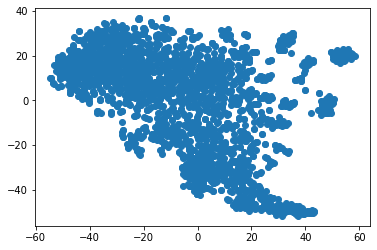

In [49]:
import matplotlib.pyplot as plt
plt.scatter(X_embedded[:,0],X_embedded[:,1])


# Performing Kmeans clustering 10 cluster-means

In [50]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_embedded)
clusters_means = kmeans.cluster_centers_
print(clusters_means.shape)

(10, 2)


## Find two centroids that are furthest away from each other

In [51]:
from scipy.spatial import distance_matrix
dist = distance_matrix(clusters_means,clusters_means)
max_centroids = np.where(dist == np.amax(dist))[0]
max_centroids


array([5, 7])

# Get indicies of the 15 images that are closest to all the centroids
 

In [52]:
indicies = {}
for i in range(clusters_means.shape[0]):
    d = kmeans.transform(X_embedded)[:, i]
    ind = np.argsort(d)[::][:15]
    indicies[i] = ind    

# Getting the 10 mean images

In [54]:
import os
import torchvision
import torch
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from time import sleep
import torch
from torch import nn
import sys
import numpy as np
sys.path.append("/content/drive/MyDrive/DLSP/Drna-master")
#from config import BATCH_SIZE, PROPOSAL_NUM, SAVE_FREQ, LR, WD, resume, save_dir, INPUT_SIZE, INPUT_SIZE_s, VAL_PROCENT, RESIZED_SIZE, RESIZED_SIZE_s


test_transform = transforms.Compose([
    transforms.Resize((300,300), Image.BILINEAR),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                 std=(0.229, 0.224, 0.225))
    ])
c_class = "Medical"
#data_list = './data/List/train_images_root.txt'
#data_root='./data/train/'
#f = open(data_list, 'r')
#data_list = f.readlines()
#f.close()
#img_paths = []
#nr_image = 15
#intlabels = {"Food": 0, "Clothes": 1, "Institution": 2, "Accessories": 3, "Transportation": 4, "Electronic": 5, "Necessities": 6, "Cosmetic": 7, "Leisure": 8, "Medical": 9}
mean_images = []
orig_images_all = [] #list of 10 list with 15 images each 
trainloader = os.listdir("TrainData/"+c_class)
for centroid in indicies.keys(): #number of ceontroids (10)each with 15 indicies 
    close_img_paths = [] # list of len(indicies[centroid]) = 15 with path to the closest images
    for idx in indicies[centroid]:
        for i,img_path in enumerate(trainloader):
            if idx == i: # if the indicies that are closest to the current centroid (idx) == i
                close_img_paths.append(img_path)
    
    orig_images = []
    for k,img in enumerate(close_img_paths):
        full_path = "TrainData/"+c_class+"/"+img
        image = Image.open(full_path).convert('RGB')
        image = test_transform(image)
        orig_images.append(image)
        if k == 0:
            mean = image/len(close_img_paths)
        else:
            mean = torch.add(mean,image/len(close_img_paths))
    mean_images.append(mean) 
    orig_images_all.append(orig_images)    



/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

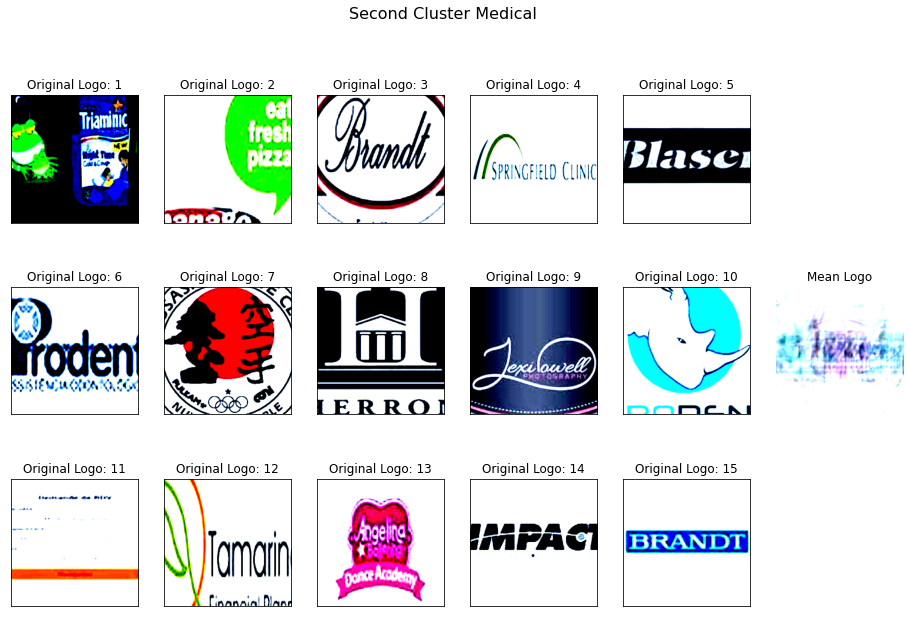

In [56]:
centroid = 4

fig = plt.figure(figsize=(16,10))

gs = fig.add_gridspec(3,6)
#ax1 = fig.add_subplot(gs[0, 0])
#ax2 = fig.add_subplot(gs[0, 1])
#ax3 = fig.add_subplot(gs[1, :])


#fig, axs = plt.subplots(3, 6)
#axs = axs.ravel()
idx = 0
for i in range(3):
  for j in range(5):
    img = torch.transpose(torch.transpose(orig_images_all[centroid][idx],0,1),1,2)
    ax = fig.add_subplot(gs[i, j])
    ax.imshow(img)    
    ax.title.set_text('Original Logo: '+ str(idx+1))
    ax.set_xticks([])
    ax.set_yticks([])
    idx+=1
axmean = fig.add_subplot(gs[:, 5])
axmean.imshow(torch.transpose(torch.transpose(mean_images[centroid],0,1),1,2))
axmean.title.set_text("Mean Logo")
plt.axis('off')
fig.suptitle('Second Cluster Medical', fontsize=16)
plt.savefig("/content/drive/MyDrive/DLSP/ChosenImages/SecondMedicalCluster4Mean.svg")
plt.show()

# Save mean images

In [ ]:
mean_images_all = np.zeros((10,3,224,224))
for i,mean_image in enumerate(mean_images):
    mean_images_all[i,:,:,:] = mean_image
np.save("/content/drive/MyDrive/DLSP/Drna-master/MeanImages/"+c_class+".npy", mean_images_all)